In [1]:
!jt -t grade3

Calculating Race Handicaps using Data Science: The Hallam Chase
===============================================================

The [Hallam Chase](http://www.thehallamchase.org.uk/index.html) is the oldest continuously run fell race in the world. It takes place every year in Sheffield around the second bank holiday in May. 
As a Sheffield resident and (once) keen fell runner I have competed myself (even [coming second in 2013](http://www.thehallamchase.org.uk/resources/Hallam_Chase_Results_2013.pdf)).
To compete in the race you must submit recent race times so you can be assigned an appropriate handicap. 
I love the idea of a handicapped race, if you run a good race you have a chance of winning overall -- but this rely relies on providing good quality handicaps to everyone. Competitors may not submit their best times or may seek to gain an advantage in some other way (to clarify, I am not suggesting this happens, merely ruminating).
This got me thinking, we have great records of fell races in the region. Could we design an automated system that automatically calculates a handicap based on recent race performance? Would such a system be able to improve on the current, tried and tested method? What an interesting proposition!
This notebook will outline the process I undertook to investigate the potential of an automated, data based handicap system for the Hallam Chase.

# Current Performance
The first thing to look at, is the performance of current handicapping. This isn't obvious, how could we say whether someone has been given too much, or too little, handicap time? 
One way to examine this is to imagine that a 'perfect race' involves everyone crossing the finish line at the same time! Of course, many may disagree, probably the person tasked with recording finish times. This isn't a realistic scenario but it serves as a starting point.
If we assume that errors in handicapping are normally distributed around zero, we can use the average finish time to calculate handicap performance (or error).

Each racer is given a handicap as seconds from the slowest person. The first person to set off has a 0 seconds handicap.
We would like to know how well a person's finish time was predicted by their handicap. To do this we need to reframe the handicap for each person as 'expected time from mean finish time'. In this way someone that runs the race slower than average has a negative handicap, a faster runner has a positive handicap (it isn't hard to see why this isn't used for the actual race).

To rescale the handicap we calculate what the mean handicap given in a race is and subtract it from the original handicap value:
$$H^{*}_i = H_i - \hat{H} $$
Where $\hat{H}$ is mean handicap.

We can calculate a runner's predicted finish time by using an individual's handicap and the mean finish time $\hat{t}$:
$$t_i = \hat{t} - H^{*}_i$$

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from analysis_tools import convert_Chase_ZScore_logs
# Connect to the FellPace Database
db_file = "C:\\PythonProjects\\FellPace\\fellpace-anon.db"
con = sqlite3.connect(db_file)

# Have to create custom STD DEV function as not in SQL LITE
import math
class std_dev:
    def __init__(self):
        self.n = 0
        self.sum = 0
        self.sq = 0

    def step(self, value):
        self.n += 1
        self.sum += value
        self.sq += value * value

    def finalize(self):
        return math.sqrt(self.sq/self.n - (self.sum/self.n * self.sum/self.n )  )
con.create_aggregate('stddev',1,std_dev)

## Summary Finish Times
It is useful to examine finishing times for Hallam Chase races. We will examine every race since 2017. Looking at times spent running the course (course times) and finishing times which include the handicap (race times). You can observe that even though the gap between the course times is relatively consistent, average handicaps can vary by several minutes between different editions of the race.

In [3]:
def map_seconds(seconds_in):
    seconds = divmod(seconds_in,60)[1]
    minutes = divmod(seconds_in,60)[0]
    hours = divmod(minutes,60)[0]
    return f"{minutes:02.0f} m, {seconds:02.2f} s"
    #return f"{hours:02.0f}:{minutes:02.0f}:{seconds:02.2f}"

sql_extract =   '''
                SELECT 
                        strftime("%Y",C.Chase_Date) as Year,
                        min(R.Time) as "Fastest Course Time",
                        max(R.Time) as "Slowest Course Time",
                        avg(R.Time) as "Average Course Time",
                        avg(R.Handicap) as "Average Handicap",
                        min(R.Time + R.Handicap) as "Fastest Race Time",
                        max(R.Time + R.Handicap) as "Slowest Race Time"
                FROM Results_Chase as R
                JOIN Chases as C ON C.Chase_ID = R.Chase_ID
                GROUP BY Year'''
Chase_Year_Data = pd.read_sql(sql_extract,con)
Chase_Year_Data.set_index('Year',inplace=True)
Chase_Year_Data_min_sec = Chase_Year_Data.applymap(map_seconds)
from IPython.display import display, HTML
display(HTML(Chase_Year_Data_min_sec.to_html()))

,Fastest Course Time,Slowest Course Time,Average Course Time,Average Handicap,Fastest Race Time,Slowest Race Time
Year,,,,,,
2017,"22 m, 30.00 s","47 m, 30.00 s","32 m, 42.23 s","09 m, 44.93 s","38 m, 41.00 s","50 m, 17.00 s"
2018,"23 m, 56.00 s","47 m, 24.00 s","32 m, 14.83 s","12 m, 2.41 s","40 m, 19.00 s","49 m, 24.00 s"
2019,"25 m, 7.00 s","47 m, 31.00 s","32 m, 47.43 s","11 m, 3.49 s","38 m, 10.00 s","52 m, 21.00 s"
2021,"21 m, 46.00 s","46 m, 1.00 s","31 m, 47.44 s","12 m, 14.41 s","40 m, 5.00 s","50 m, 50.00 s"
2022,"24 m, 43.00 s","45 m, 29.00 s","32 m, 13.42 s","14 m, 28.07 s","41 m, 54.00 s","53 m, 20.00 s"
2023,"24 m, 53.00 s","50 m, 49.00 s","32 m, 25.94 s","15 m, 33.39 s","44 m, 35.00 s","51 m, 52.00 s"


## Quality of prediction
Using the equations above, we can calculate a 'predicted finishing time' for every competitor in the race and plot that against their actual finishing time. The root mean squared error (RMSE) indicates how far, on average, each prediction was away from reality. The lower this value the 'better' the prediction. Of course, it would be impossible to get RMSE to zero, but generally a lower RMSE would lead to a 'tighter' race where runners would reach the finishing line more closely together than a race with a high RMSE.
The first place and last place from each race is highlighted green and red respectively. In each race these are the runners that are furthest away from the 'equality line' placed on the plot (the line where Predicted Time = Race Time). It is impossible to know whether this is due to an inappropriate handicap or abnormal performance from each runner.
Overall, I think it is impressive how well handicaps are assigned each year. The winner comes from across the whole spectrum of race times each year (arguably the very fastest runners have their work cut out, but there are other races for them).

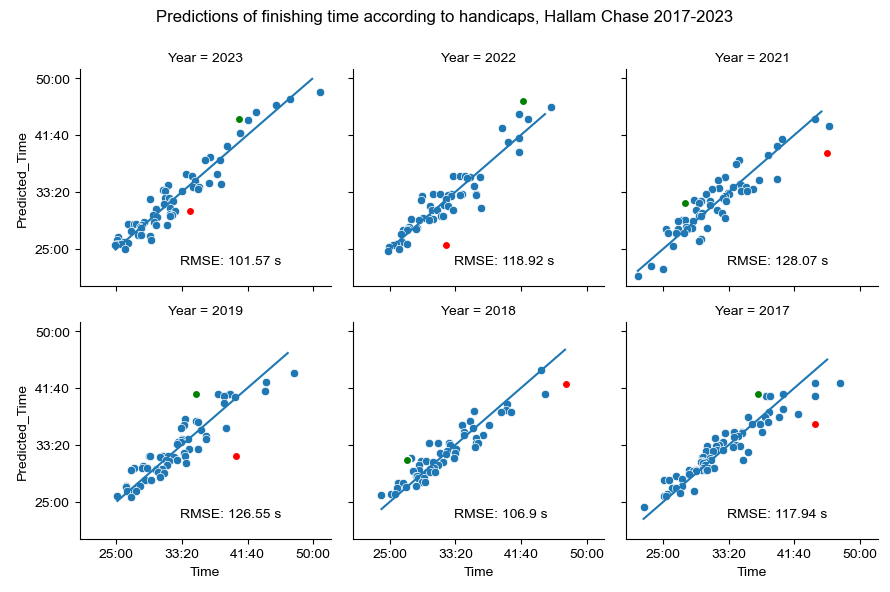

In [4]:
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings('ignore')
sql_extract =   'Select RC.Racer_ID as Racer_ID, RC.Time as Time,RC.Handicap as Handicap, strftime("%Y",C.Chase_Date) as Year  FROM Results_Chase as RC ' \
                'LEFT JOIN Chases as C ' \
                'ON C.Chase_ID = RC.Chase_ID ' \
                'ORDER BY RC.Handicap'

def xy(*args,**kwargs):
    xmin = np.min(args[0])
    xmax = np.max(args[0])
    x = np.arange(xmin,xmax,100)
    plt.plot(x,x)
def print_RMSE(*args,**kwargs):
    import matplotlib.pyplot as mpp
    x=args[0]
    y=args[1]
    e = x-y
    e2 = e**2
    e2m = np.mean(e2)
    RMSE = np.sqrt(e2m)
    ax = plt.gca()
    ax.text(.4,.1,f'RMSE: {np.round(RMSE,2)} s',transform=ax.transAxes)
def highlight_winners_losers(*args, **kwargs):
    '''Passing columns in order Course Time, Predicted Time, Handicap'''
    course_times = args[0] + args[2]
    i_win = np.argmin(course_times)
    i_lose = np.argmax(course_times)
    Time = args[0].values
    PredTime = args[1].values
    plt.scatter(x=Time[i_win],y=PredTime[i_win],c='g',marker='o',edgecolors='w',linewidths=1)
    plt.scatter(x=Time[i_lose],y=PredTime[i_lose],c='r',marker='o',edgecolors='w',linewidths=1)
    
    
def axis_time(seconds_in,pos):
    seconds = divmod(seconds_in,60)[1]
    minutes = divmod(seconds_in,60)[0]
    hours = divmod(minutes,60)[0]
    return f"{minutes:02.0f}:{seconds:02.0f}"
    
data_chase = pd.read_sql(sql_extract,con)
data_chase_agg = data_chase[['Year','Time','Handicap']].groupby('Year').transform(np.mean)
data_chase['HandicapN'] = data_chase['Handicap'] - data_chase_agg['Handicap']
data_chase['Predicted_Time'] = data_chase_agg['Time'] - data_chase['HandicapN']
g = sns.FacetGrid(data_chase,col='Year',col_wrap=3)
g.map(sns.scatterplot,'Time','Predicted_Time')

g.map(print_RMSE,'Time','Predicted_Time')
for axis in g.axes:
    axis.xaxis.set_major_formatter(axis_time)
    axis.yaxis.set_major_formatter(axis_time)
g.map(xy,'Time')
g.map(highlight_winners_losers,'Time','Predicted_Time','Handicap')
plt.subplots_adjust(top=0.88)
g.fig.suptitle('Predictions of finishing time according to handicaps, Hallam Chase 2017-2023')
sns.set_theme()

# Does your Handicap predict performance?
Another metric to examine might be whether the handicap you're given is related to your overall position. In other words do final race positions have any relationship to the handicap you were given? Do racers starting first (with a low handicap) finish in better positions to those starting later (with a high handicap).
A simple way to examine this is with Pearson's correlation ($r$). The $r$ value varies between 0 and 1 and indicates the quality of a (linear) relationship. In other words, if the r value is 1, then the person starting first finishes first, the person starting second finishes second and so on. If the r value is -1 then the person starting last finishes first, the person starting second to last finishes second, and so on. What we want is an r value of 0 -- this indicates that there is no relationship between handicap and finishing position.
The table below shows that the handicap has done a great job of 'mixing' up the competitors, there are no strong relationships between handicap and finishing position. In some years the faster runners have a slight advantage, in other years the slower runners have a slight advantage but the effect is very small. 

In [5]:
chase_corr = data_chase[['Handicap','Year','Time']]
chase_corr['Time'] = chase_corr['Handicap'] + chase_corr['Time']
chase_corr['H_rank'] = chase_corr.groupby('Year',group_keys=False,sort=False)['Handicap'].rank()
chase_corr['T_rank'] = chase_corr.groupby('Year',group_keys=False,sort=False)['Time'].rank()

from scipy.stats import pearsonr
pearsons = chase_corr.groupby('Year').apply(lambda x: pearsonr(x['H_rank'],x['T_rank'])[0])
HTML(pd.DataFrame(pearsons,columns=['Pearson\'s r']).to_html())


,Pearson's r
Year,
2017,-0.200918
2018,-0.200616
2019,0.172618
2021,0.115444
2022,0.295902
2023,0.233319


# Predicting Handicaps
So the question arises, could the handicap times be improved using racing data? Before we can ask this question, we have to gather data. This was done through a semi-automated process of scraping results tables from local races and collating all of this data into a single database.

### No standards
The first obvious thing to notice when conducting this exercise was the variety of different data formats used when recording race data. This included tables on a webpage, JSON files gathered via an API or an excel file stored in the cloud somewhere. Different methods had to be created that could deal with all of these different formats.
Secondly, I was keen to record as much rich data as I could and that included the category of each runner. This is when I realised that there is similarity between categories but no definitive set. While typically there was a male/men's category there could be a female (F), women's (W) or ladies (L). Does the race recognise under 23? Under 21? Under 18? Is the main age range 'senior' or 'open'? Do age categories go up by 5 or 10 years? The answer is, all of these and many more. Given that I haven't used age categories in this analysis, I have spent an inordinate amount of time coalescing all of these options into a finite set of categories.

### Who's who?
Another common issue arises when trying to link lots of small sets of data (race results) from multiple different locations. Names. Although the fell racing scene has moved on in recent years I still remember the years of writing my name in shaky biro on a tiny slip of paper in order to get my race number. As a result of my horrendous hand-writing I often raced under a name which bore only a passing resemblance to that on my birth certificate. As you'd expect there also isn't any other personal information given in race results which might be useful to confirm identity (date of birth for example). As a result, it can often be difficult to work out whether two people with similar names are the actually the same person, or not.
To try and combat this I meticuously went through the whole data set looking at potential close matches of names and assigning them the same identity, or not. This was mostly a matter of judgement. All I had to go off was the person's name and their race performances. If names were close enough and their race times were similar, they would often be combined. However, quite often it wasn't obvious that the difference in name was a spelling mistake or sobriquet (Dave for David for example). It could be a perfectly reasonable alternative that _is_ a different person. For that reason I erred on the side of caution. 

### The data
To make the data capture task manageable I focused on a specific races over the same time period as our results for the Chase (2017 - 2023). The plot below shows the data we have captured. It lists the races, showing the distribution of race times and the number of runners we have for each race (including all years/instances of the race we have captured).


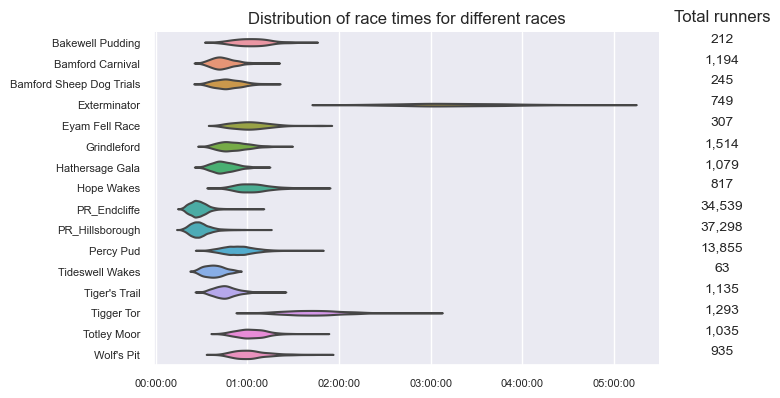

In [6]:
#Get Times from all races to observe all results
import pandas as pd
sql_extract_zscore = '''WITH Racers_Results AS
(
    SELECT Racer_ID, Time, Race_ID
    FROM Results    
),

Races_Rename AS
(
    SELECT CASE
    WHEN Race_Name LIKE "Parkrun_endcliffe%" THEN "PR_Endcliffe"
    WHEN Race_Name LIKE "Parkrun_hillsborough%" THEN "PR_Hillsborough"
    ELSE Race_Name
    END            AS Race_Name,
    strftime("%Y",Race_Date) AS Year,
    Race_ID
    FROM   Races
),
Results_joined AS
(
    SELECT Racer_ID, C.Race_Name, C.Year, AVG(Time) as Time, C.Race_ID
    FROM Racers_Results
    JOIN Races_Rename as C
    ON C.Race_ID = Racers_Results.Race_ID
    GROUP BY Racer_ID, C.Race_ID
)


SELECT R.Racer_ID,R.Race_Name, R.Year, R.Time
FROM Results_joined as R
'''

def axis_time_hms(seconds_in,pos):
    seconds = divmod(seconds_in,60)[1]
    minutes_t = divmod(seconds_in,60)[0]
    hours = divmod(minutes_t,60)[0]
    minutes = divmod(minutes_t,60)[1]
    return f"{hours:02.0f}:{minutes:02.0f}:{seconds:02.0f}"

from scipy.stats import zscore
data_races = pd.read_sql(sql_extract_zscore,con)
data_races.sort_values('Race_Name',inplace=True)

g = sns.catplot(data=data_races,y='Race_Name',x='Time',kind='violin',inner=None).set(title='Distribution of race times for different races')
g.ax.xaxis.set_major_formatter(axis_time_hms)
g.ax.set_xlabel(None)
g.ax.set_ylabel(None)
g.ax.set_xticks([0,3600,7200,10800,14400,18000])
g.tick_params(labelsize=8)
fig = plt.gcf()
fig.set_size_inches(15,4)
plt.subplots_adjust(right=0.8)
xmax = g.ax.get_xlim()[1]
#Plot numbers on right of plot
plt.text(xmax+xmax/8,-1,'Total runners',ha='center')
for i,race in enumerate(data_races['Race_Name'].unique()):
    this_race = data_races.loc[data_races['Race_Name'] == race]
    runners = this_race.shape[0]
    plt.text(xmax+xmax/8,i,f'{runners:,}',ha='center',fontsize=10)

    

# Is that normal?
You may notice that the shape showing each of the race distributions has a thin tail trailing off towards the right (this is most obvious for the ParkRun, PR, data). This effect is caused by the nature of running events. There tends to be a 'hard' limit at one end of the results, you are generally limited to how fast you run a race. However, there is (theoretically) no limit at the slower end, you can take as long as you like, providing that the person with the stopwatch agrees to wait for you (my thoughts here are drawn to the person completing the London Marathon in a suit of armour over several days). As a result, race results are not 'normal' distributions but 'log-normal'. Log-normal distributions are skewed in one direction.
I would like to compare performance between races by taking a [z-score](https://en.wikipedia.org/wiki/Standard_score). A z-score is a standard way of measuring a value from any normal distribution (a z-score of 0 means a value is equal to the mean/average value). In order for me to do this, I have to transform our race time to normal distributions. 
If I transform all the race times like so:
$$t^*_i = log(t_i) $$
The race times should become more normally distributed. A plot of each race now shows a much more symmetrical shape (I've removed axis labels as log(time) doesn't mean much).

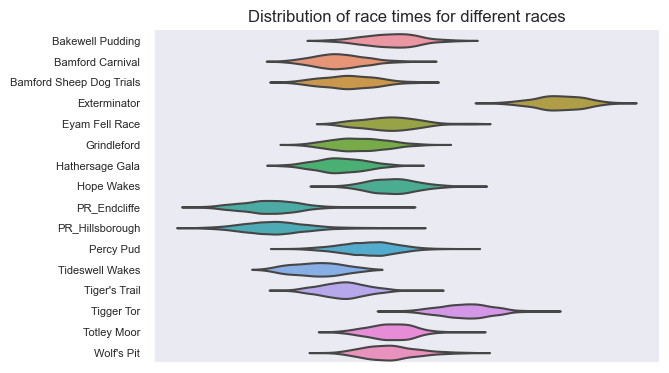

In [7]:
data_races['Timeln'] = np.log(data_races.Time)
g = sns.catplot(data=data_races,y='Race_Name',x='Timeln',kind='violin',inner=None).set(title='Distribution of race times for different races')
g.ax.set_xlabel(None)
g.ax.set_ylabel(None)
g.ax.set_xticks([])
g.tick_params(labelsize=8)
fig = plt.gcf()
fig.set_size_inches(15,4)
plt.subplots_adjust(right=0.8)
xmax = g.ax.get_xlim()[1]


With log transformed times for all races (including the Chase) we can calculate z-scores and compare how race times from different events compare to race times from the Hallam Chase!

### Why Z-Scores
I chose to use Z-scores rather than race times as they are measure of _relative_ performance. It doesn't matter how long the race is, Z-scores can be compared to determine whether one time is _better_ than another. Another great advantage is that it is a better way of combining data over multiple years. Let us imagine that for a particular edition of a race, the weather is particularly bad, howling wind and pummeling rain. The times are much slower compared to previous years. It would be bad practice to group all this data together, excellent performances would look mediocre compared to an edition of the race when weather was fine. In order to combine the data we would have to standardise the times in some way -- Z-scores are a great way to do this.

# Race vs Chase
If we want to predict Chase times based on other race performances, we need runners in our database that have competed in one of the races we've collected _and_ in the Hallam Chase between 2017 and 2023.
A quick database query can tell us how much of an overlap we have.

In [8]:
SQL_query = '''
                SELECT Results_Chase.Racer_ID FROM Results_Chase
                INNER JOIN Results
                ON Results_Chase.Racer_ID = Results.Racer_ID
'''
results = pd.read_sql(SQL_query,con)
print(f'There are {len(results.Racer_ID.unique())} racers that have run in the Hallam Chase and one of our races.\nThey have run in {len(results)} races between them.')

There are 147 racers that have run in the Hallam Chase and one of our races.
They have run in 5450 races between them.


That is a lot of races overall! However from interrogating the data I know that most of these are from the two Parkruns that I gathered the data from. The event is weekly and so if you're a regular runner it's possible to tot up a lot of races in a year!

Let's have a look at how the Z-Scores from one of the Parkruns compares to the Chase results. For each data point I'm comparing run results with Chase results __from the same year__. For example, your Z-Score from a parkrun in 2018 will be compared with your Hallam Chase from 2018. If you didn't run the Chase that year, no data is shown. There are some subtleties here that I've chosen to ignore. The Chase is run in May. So it may be prudent to re-scale the year to run from May to May. For simplicity I haven't done that in this case as I don't think the results would be worth it.
Let's look at the comparison between Endcliffe Parkrun and the Hallam Chase.

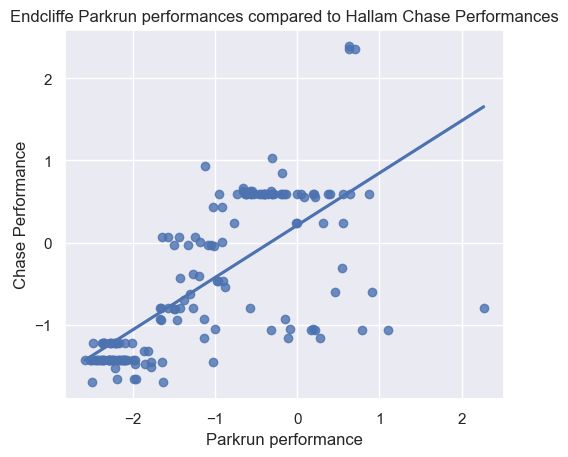

In [9]:
sql_extract_zscore = '''WITH Chase_Yrs AS
(
    SELECT Racer_ID, strftime("%Y",CD.Chase_Date) as Year, ZScore_log
    FROM Results_Chase
    JOIN Chases as CD
    ON CD.Chase_ID = Results_Chase.Chase_ID
),

Racers_Results AS
(
    SELECT Racer_ID, ZScore_log, Race_ID
    FROM Results    
),

Races_Rename AS
(
    SELECT CASE
    WHEN Race_Name LIKE "Parkrun_endcliffe%" THEN "PR_Endcliffe"
    WHEN Race_Name LIKE "Parkrun_hillsborough%" THEN "PR_Hillsborough"
    ELSE Race_Name
    END            AS Race_Name,
    strftime("%Y",Race_Date) AS Year,
    Race_ID
    FROM   Races
),
Results_joined AS
(
    SELECT Racer_ID, C.Race_Name, C.Year, avg(ZScore_log) as ZScore, C.Race_ID
    FROM Racers_Results
    JOIN Races_Rename as C
    ON C.Race_ID = Racers_Results.Race_ID
    GROUP BY Racer_ID, C.Race_ID
)


SELECT R.Racer_ID,R.Race_Name, R.Year, R.ZScore, HC.ZScore_log as HCScore
FROM Results_joined as R
LEFT JOIN Chase_Yrs as HC
ON HC.Racer_ID = R.Racer_ID
AND HC.Year = R.Year
WHERE R.Racer_ID IN (SELECT Racer_ID FROM Results_Chase)
AND HCScore IS NOT NULL'''

data_Zs = pd.read_sql(sql_extract_zscore,con)
data_PR = data_Zs.loc[data_Zs.Race_Name == 'PR_Endcliffe']
sns.regplot(data=data_PR,x='ZScore',y='HCScore',ci=0).set(xlabel='Parkrun performance',ylabel='Chase Performance',title='Endcliffe Parkrun performances compared to Hallam Chase Performances')
plt.gca().set_aspect('equal')

Here we are comparing Z-Scores, the lower the number, the faster the time. You may be able to notice that some data points are clustered in horizontal lines. This is when a runner has performed the event multiple times in a year and each is assigned the same Chase performance value (as there is only one each year).
Some of these horizontal clusters cover quite a range of performances -- some are a lot faster than others. This data reveals something quite tricky about Parkrun as a comparison event -- it's not a race! One week you may choose to go for a PB, the next have a nice chat with a friend. However there may be useful information in there somewhere. Firstly, how do we deal with someone that has run the event many times in a single year? Which performance do we take? We could take the average but this might lead us to use a value that is unrepresentative of reality (an equal number of 'runs' and 'walks' would put the average between the two). Instead I'll choose a compromise, the 75th percentile performance. In practice this would lead to the fastest of two runs, the second fastest from four etc. We're not just taking the fastest but choosing one that we hope represents a 'good effort'.
Let's change our processing and have a look.

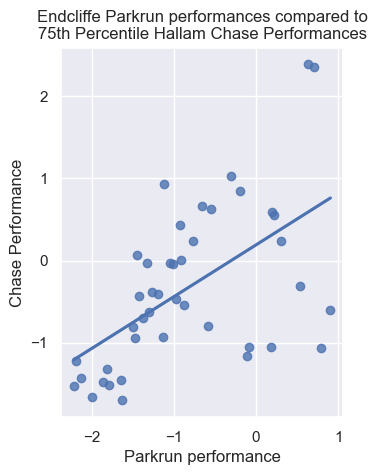

In [10]:
# For races with multiple results can return the Xth percentile of performance with this function
class XPercentile:
    percentile = 0.2
    def __init__(self):
        self.values = []

    def step(self, value):
        self.values.append(value)

    def finalize(self):
        self.values.sort()
        upper_quartile_index = round(self.percentile * (len(self.values)))-1
        return self.values[upper_quartile_index]
        #return self.values[0]

con.create_aggregate("XPercentile",1,XPercentile)
#Get Zscores of runners from different events
sql_extract_zscore = '''WITH Chase_Yrs AS
(
    SELECT Racer_ID, strftime("%Y",CD.Chase_Date) as Year, ZScore_log
    FROM Results_Chase
    JOIN Chases as CD
    ON CD.Chase_ID = Results_Chase.Chase_ID
),

Racers_Results AS
(
    SELECT Racer_ID, ZScore_log, Race_ID
    FROM Results
    
),

Races_Rename AS
(
    SELECT CASE
    WHEN Race_Name LIKE "Parkrun_endcliffe%" THEN "PR_Endcliffe"
    WHEN Race_Name LIKE "Parkrun_hillsborough%" THEN "PR_Hillsborough"
    ELSE Race_Name
    END            AS Race_Name,
    strftime("%Y",Race_Date) AS Year,
    Race_ID
    FROM   Races
),
Results_joined AS
(
    SELECT Racer_ID, C.Race_Name, C.Year, XPercentile(ZScore_log) as ZScore, C.Race_ID
    FROM Racers_Results
    JOIN Races_Rename as C
    ON C.Race_ID = Racers_Results.Race_ID
    GROUP BY Racer_ID, C.Race_Name, C.Year
)


SELECT R.Racer_ID,R.Race_Name, R.Year, R.ZScore, HC.ZScore_log as HCScore
FROM Results_joined as R
LEFT JOIN Chase_Yrs as HC
ON HC.Racer_ID = R.Racer_ID
AND HC.Year = R.Year
WHERE R.Racer_ID IN (SELECT Racer_ID FROM Results_Chase)
AND HCScore IS NOT NULL'''



from scipy.stats import zscore
data_Zs = pd.read_sql(sql_extract_zscore,con)
data_Zs.sort_values('Race_Name',inplace=True)
data_PR = data_Zs.loc[data_Zs.Race_Name == 'PR_Endcliffe']
sns.regplot(data=data_PR,x='ZScore',y='HCScore',ci=0).set(xlabel='Parkrun performance',ylabel='Chase Performance',title='Endcliffe Parkrun performances compared to\n75th Percentile Hallam Chase Performances')
plt.gca().set_aspect('equal')
sns.set_theme()

Things look a lot clearer now. A runner's performance in a single year is now represented by a single data point. While the data looks 'noisy', there does seem to be a nice linear relationship in there somewhere. There are good reasons why some datapoints might belong to a relationship, while others are 'noisy'. As discussed, at a Parkrun there will be a lot of people attending for social reasons. A time does not necessarily represent someone's 'best effort'. However, for many people it will! Is there a way of excluding the social runs and just focusing on best efforts?
There is a fantastic algorithm (if I was being rash, I might go as far to say my favourite algorithm) called RANSAC (random sampling and consensus). It's a very versatile process that finds data points belonging to a particular relationship, and excludes those that do not. I first came across it as a way to find shapes in 3D data (and I've loved it ever since). In the case of our run data, RANSAC will find a line of best fit that gets 'consensus' I.e. it's the 'best' line in our data. After that it can reject any data points that don't belong to this line of best fit, effectively squirreling out all the data points that belong to 'best effort runs'. 
Let's apply RANSAC to this data and see what it looks like, I'll keep in the removed data points but grey them out.

In [18]:
# Experiment with filtering data with a Ransac regressor
from sklearn import linear_model
#get test dataset
def find_inliers(group):
    X = group.ZScore.values.reshape([-1,1])
    y = group.HCScore.values.reshape([-1,1])
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X,y)
    
    return pd.Series(ransac.inlier_mask_)

def plot_inlier_outlier(x,y,inlier,**kwargs):
    x_in = x.loc[inlier == True]
    y_in = y.loc[inlier == True]
    
    x_out = x.loc[inlier == False]
    y_out = y.loc[inlier == False]
    sns.regplot(x=x_in,y=y_in,ci=0)
    sns.scatterplot(x=x_out,y=y_out,s=60,color=[0.6,0.6,0.6],alpha=0.5).set(xlabel='Race performance',ylabel='Chase performance')
    
data_Zs['inlier'] = data_Zs.groupby('Race_Name',group_keys=False,sort=True,as_index=False).apply(find_inliers).values

data_PR = data_Zs.loc[data_Zs.Race_Name == 'PR_Endcliffe']
plot_inlier_outlier(data_PR['ZScore'],data_PR['HCScore'],data_PR['inlier'])
plt.gca().set(title='Performance comparison with RANSAC')
sns.set_theme()


KeyboardInterrupt: 

The RANSAC has cleaned up the plot considerably! It looks like thise approach will give us some nice relationships that we can work with. Let's do the same but for every race we have data for.

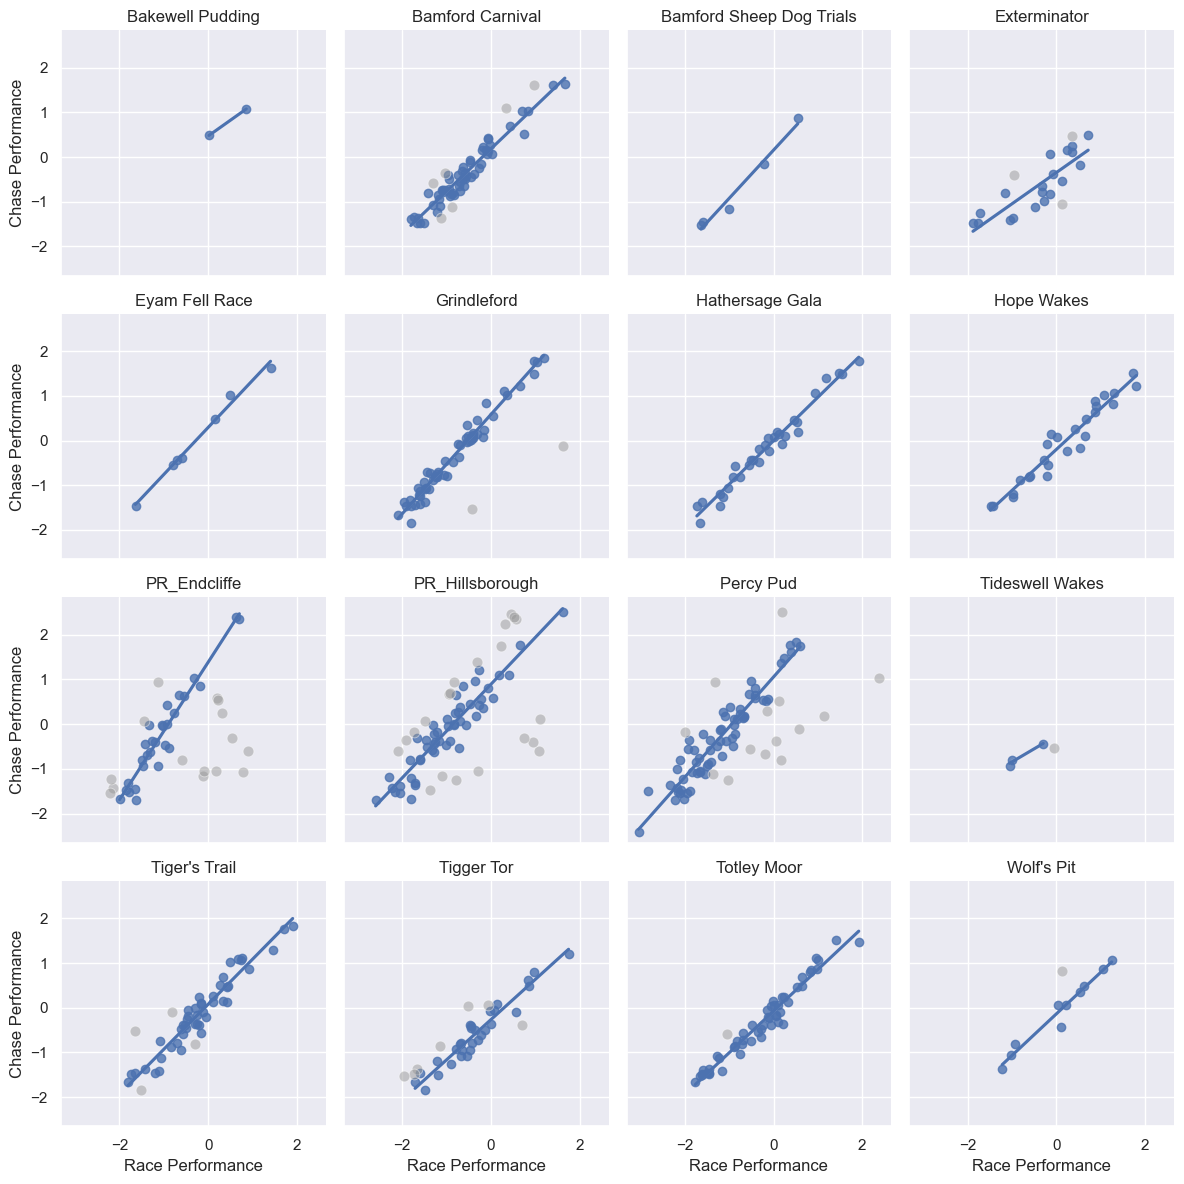

In [12]:

g = sns.FacetGrid(data=data_Zs,col='Race_Name',col_wrap=4).set_titles("{col_name}")
g.map(plot_inlier_outlier,"ZScore","HCScore","inlier")
g.set_xlabels('Race Performance').set_ylabels('Chase Performance')
plt.show()

# Creating our models
RANSAC has done a decent job of separating noisy data points for each of the races. Hopefully the linear relationships we have uncovered will be useful in predicting Hallam Chase race times.
To do this fairly, we should follow the process below:
1. Remove a year's worth of data -- this is the data we'll be predicting
2. With the remaining data, calculate our linear relationships that link a race's time to the Hallam Chase times
3. Use the race performances in the data from step (1) to predict Hallam Chase times
4. Repeat for all years to see how well the method works!

## Predicting a time
The way we predict a Hallam Chase time is to use a linear relationship or 'model'. This model will be in the form:
$$P_{Chase} = A \times P_{race} + B $$
In this case I've used $P$ to denote performance -- the Z-Scores we have calculated for each runner. To transform these performances back into race times we first transform back into our log-transformed times (we use the mean and standard deviation of that race to do so) and then take the inverse log (exponential) to end up with the race time in seconds. Simple!

Let's do this, we'll make a similar plot to what we've seen before but this time we'll be comparing the recorded Chase time to those that we've predicted using the method above.

__NB:__ you can see in the plots above that some races have very few data points, these will be removed from the analysis.

In [13]:
import numpy as np
warnings.filterwarnings('ignore')
all_data = pd.DataFrame()

for chosen_year in ['2023','2022','2021','2019','2018','2017']:
    data_train = data_Zs.loc[(data_Zs['Year'] != chosen_year) & (data_Zs['inlier'])]
    data_test = data_Zs.loc[(data_Zs['Year'] == chosen_year) & (data_Zs['inlier'])]

    max_resid = 10.9
    coeffs = data_train.groupby('Race_Name').apply(lambda x: np.polyfit(x['ZScore'],x['HCScore'],1))
    data_train['Resid'] = data_train.apply(lambda x: x['HCScore'] - np.polyval(coeffs[x['Race_Name']],x['ZScore']),axis=1)

    data_train_clean = data_train.drop(data_train[data_train['Resid'].abs()>max_resid].index,axis=0)
    # New coeffs with clean data
    coeffs = data_train_clean.groupby('Race_Name').apply(lambda x: np.polyfit(x['ZScore'],x['HCScore'],1))

    #No earlier data for these races -- REMEDY!
    data_test = data_test.drop(data_test[data_test['Race_Name'] == 'Bamford Sheep Dog Trials'].index,axis=0)
    data_test = data_test.drop(data_test[data_test['Race_Name'] == 'Eyam Fell Race'].index,axis=0)
    data_test = data_test.drop(data_test[data_test['Race_Name'] == 'Tideswell Wakes'].index,axis=0)
    data_test = data_test.drop(data_test[data_test['Race_Name'] == 'Bakewell Pudding'].index,axis=0)

    # Parkrun is just bloody garbage, getting rid!
    #data_test = data_test.drop(data_test[data_test['Race_Name'] == 'PR_Hillsborough'].index,axis=0)
    #data_test = data_test.drop(data_test[data_test['Race_Name'] == 'PR_Endcliffe'].index,axis=0)
    #data_test = data_test.drop(data_test[data_test['Race_Name'] == 'Percy Pud'].index,axis=0)

    data_test['predZ'] = data_test.apply(lambda x: np.polyval(coeffs[x['Race_Name']],x['ZScore']),axis=1)
    
    data_test_mn = data_test[['Racer_ID','predZ','HCScore']].groupby('Racer_ID',as_index=False).mean()
    data_test_mn['Predicted_Time'] = convert_Chase_ZScore_logs(con,data_test_mn['predZ'],chosen_year) 
    data_test_mn['Time'] = convert_Chase_ZScore_logs(con,data_test_mn['HCScore'],chosen_year)
    data_test_mn['Year'] = chosen_year
    data_test_mn['Prediction method'] = 'New'
    this_data = data_test_mn[['Racer_ID','Predicted_Time','Time','Prediction method','Year']]
    all_data = pd.concat([all_data,this_data])
all_data['Handicap'] = all_data.groupby('Year',group_keys=False,sort=False).apply(lambda x: x['Predicted_Time'].max()-x['Predicted_Time'] )
all_data['Race Time'] = all_data['Time'] + all_data['Handicap']
all_data['Time from first'] = all_data.groupby('Year',group_keys=False,sort=False).apply(lambda x: x['Race Time'] - x['Race Time'].min())




To make a prediction will take the average of all the races an individual has competed in.

# Equivalent errors
We don't have data for all of the Hallam Chase times, not everyone has run a race that we have captured. To compare things equivalently, we remove those people from our Hallam Chase data completely.

Let's plot the predicted times against the actual race times. In this way we can visualise the quality of our predictions. The close the points are on a straight $x=y$ line the better the predictions. We can also look at the RMSE for our 'new' and 'traditional' methods to see how they compare. The lower the RMSE the better the predictions.

In [14]:
data_chase_all = pd.DataFrame()
for chosen_year in ['2023','2022','2021','2019','2018','2017']:
    data_test = all_data.loc[all_data.Year == chosen_year]
    IDs = tuple(data_test['Racer_ID'].unique())
    sql_extract = f'''
                    Select Racer_ID, RC.Time as Time,RC.Handicap as Handicap, strftime("%Y",C.Chase_Date) as Year  FROM Results_Chase as RC
                    INNER JOIN Chases as C
                    ON C.Chase_ID = RC.Chase_ID
                    WHERE RC.Racer_ID in {IDs}
                    ORDER BY RC.Handicap
                    '''
    data_chase = pd.read_sql(sql_extract,con)
    data_chase = data_chase.loc[data_chase['Year'] == chosen_year]
    #Normalise the handicaps
    data_chase['Handicap'] = data_chase['Handicap'] - data_chase['Handicap'].min()
    meanTime = data_chase['Time'].mean()
    meanHand = data_chase['Handicap'].mean()
    data_chase_agg = data_chase[['Year','Time','Handicap']].groupby('Year').transform(np.mean)
    data_chase['HandicapN'] = data_chase['Handicap'] - meanHand
    data_chase['Predicted_Time'] = meanTime - data_chase['HandicapN']
    data_chase['Prediction method'] = 'Traditional'
    
    data_chase_all = pd.concat([data_chase_all,data_chase[['Predicted_Time','Time','Prediction method','Year','Racer_ID', 'Handicap']]])
data_chase_all['Race Time'] = data_chase_all['Time']+data_chase_all['Handicap']
data_chase_all['Time from first'] = data_chase_all.groupby('Year',group_keys=False,sort=False).apply(lambda x: x['Race Time'] - x['Race Time'].min())


#Calculate the RMSE for each year
data_chase_all['error'] = data_chase_all.apply(lambda x: x['Predicted_Time'] - x['Time'],axis=1)

all_data['error'] = all_data.apply(lambda x: x['Predicted_Time'] - x['Time'],axis=1)

race_errors = all_data.groupby('Year').apply(lambda x: np.sqrt(np.mean(x['error']**2)))
chase_errors = data_chase_all.groupby('Year').apply(lambda x: np.sqrt(np.mean(x['error']**2)))

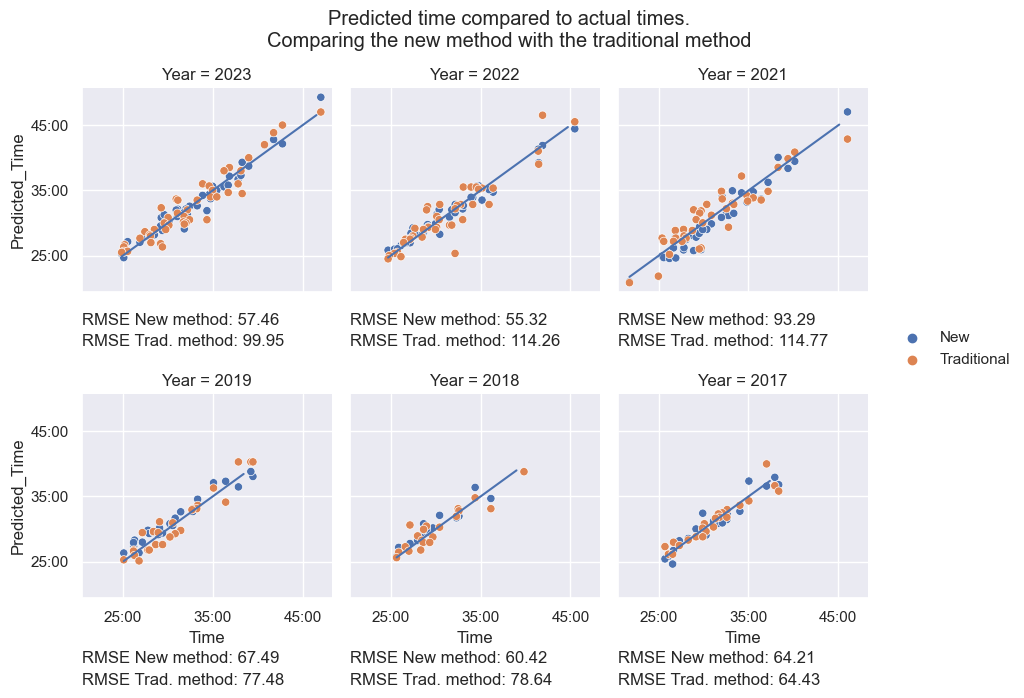

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
def xy(*args,**kwargs):
    xmin = args[0].min()
    xmax = args[0].max()
    x = np.arange(xmin,xmax,100)
    plt.plot(x,x)
    
# Merge the handicaps onto each of the data collections
#all_data = all_data.merge(data_chase_all[['Racer_ID','Year','Handicap']],on=['Racer_ID','Year'],suffixes=['','_alt'],how='left')
#data_chase_all = data_chase_all.merge(all_data[['Racer_ID','Year','Handicap']],on=['Racer_ID','Year'],suffixes=['','_alt'],how='left')

allD = pd.concat([all_data,data_chase_all])

g = sns.FacetGrid(allD,col='Year',col_wrap=3)
g.map(sns.scatterplot,'Time','Predicted_Time','Prediction method')
g.add_legend()
g.map(xy,'Time')
plt.subplots_adjust(hspace=0.5,bottom=0.0,top=0.85)
for ax,col_name in zip(g.axes.flat, g.col_names):
    x = ax.get_xlim()[0]
    y = ax.get_ylim()[0]
    gap1 = 300 if col_name in ['2023','2022','2021'] else 600
    ax.text(x,y-gap1,f'RMSE New method: {race_errors.loc[col_name]:.2f}')
    gap2 = 500 if col_name in ['2023','2022','2021'] else 800
    ax.text(x,y-gap2,f'RMSE Trad. method: {chase_errors.loc[col_name]:.2f}')
    ax.set_xticks([1500,2100,2700])
    ax.set_yticks([1500,2100,2700])
    ax.xaxis.set_major_formatter(axis_time)
    ax.yaxis.set_major_formatter(axis_time)
g.fig.suptitle('Predicted time compared to actual times.\nComparing the new method with the traditional method')
plt.show()

Both our new method and the traditional handicapping method follow a straight line well (the odd stray runner can be seen here and there). However examining the RMSE values, it does seem that our new method is making improved predictions! It is difficult to visualise in the plot above though, instead lets plot each runner according to the time they passed the finish line. 

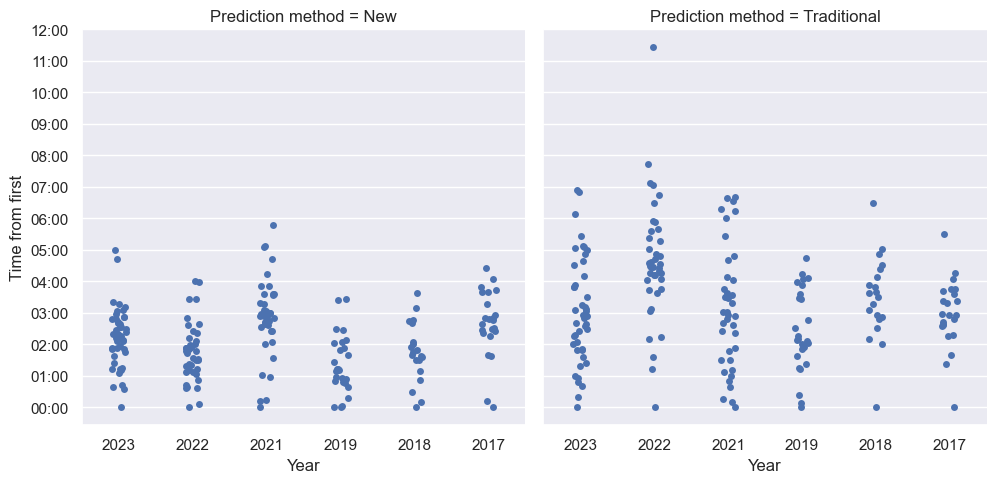

In [16]:
g = sns.catplot(data=allD, y='Time from first', x='Year', col='Prediction method')
g.set(yticks=[0,60,120,180,240,300,360,420,480,540,600,660,720])
for axis in g.axes:
    for axes in axis:
        axes.yaxis.set_major_formatter(axis_time)
plt.show()

We can see how the 'new' handicap system produces a much tighter field. Sometimes the winner is out in front, but the bulk of the runners are generally clustered quite tightly.
## Mixing it up
Earlier we examiner the relationship between the handicap a runner was given and their finishing position. If done effectively a handicap should eliminate any advantage a runner gains from a higher running speed. In other words there should be no relationship between handicap and finishing position -- something we measured using Pearson's r. Does our new handicap still 'mix' the runners up effectively?
I've attempted a fancy plot for this. On the x-axis you can see the finishing position of each runner for each race. Data points are coloured according to the handicap they received. Runners given no, or very little handicap are a dark purple and colour transitions to bright yellow for the largest handicaps (our fastest runners). I should clarify that due to the differeing number of runners we were able to include each year, earlier races won't contain as bright a yellow colour. The colour corresponds to the _rank_ of the handicap within that year, not the absolute value.

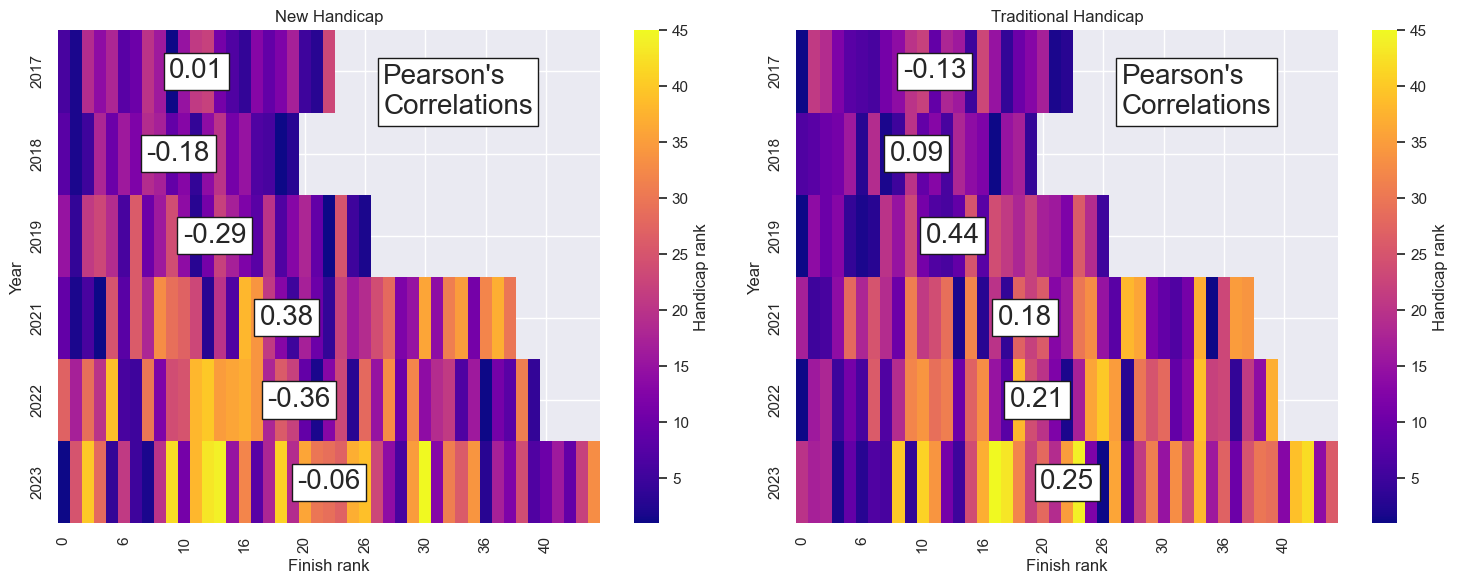

In [17]:
#Trying a funky grid plot
allD['Finish rank'] = allD.groupby(['Year','Prediction method'],group_keys=False,sort=False)['Race Time'].rank(method='first')
allD['Handicap rank'] = allD.groupby(['Year','Prediction method'],group_keys=False,sort=False)['Handicap'].rank(method='first')

#Calculate correlations
from scipy.stats import pearsonr
r = allD.groupby(['Year','Prediction method']).apply(lambda x: pearsonr(x['Finish rank'],x['Handicap rank'])[0])


fig, (ax1,ax2) = plt.subplots(1,2)

from matplotlib.ticker import FormatStrFormatter
NewMap = allD.loc[allD['Prediction method'] == 'New'][['Year','Finish rank','Handicap rank']].pivot(index='Year',columns='Finish rank',values='Handicap rank')
g = sns.heatmap(NewMap,cmap='plasma', ax = ax1,cbar_kws={'label': 'Handicap rank'})
g.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
g.set(title='New Handicap')



TradMap = allD.loc[allD['Prediction method'] == 'Traditional'][['Year','Finish rank','Handicap rank']].pivot(index='Year',columns='Finish rank',values='Handicap rank')
g = sns.heatmap(TradMap,cmap='plasma', ax = ax2,cbar_kws={'label': 'Handicap rank'})
g.set(title='Traditional Handicap')
g.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#Assuming indexing values the same for both heatmaps
for i,year in enumerate(NewMap.index):
    this_x = len(NewMap.loc[str(year)].dropna())/2
    this_r = r[(str(year),'New')]
    this_r_t = r[(str(year),'Traditional')]
    ax1.text(this_x,i+0.5,f'{this_r:0.2f}',fontsize=20,ha='center',va = 'center',bbox={'facecolor':'w','edgecolor':'k'})
    ax2.text(this_x,i+0.5,f'{this_r_t:0.2f}',fontsize=20,ha='center',va = 'center',bbox={'facecolor':'w','edgecolor':'k'})
ax1.text(27,0.75,f'Pearson\'s\nCorrelations',fontsize=20,ha='left',va = 'center',bbox={'facecolor':'w','edgecolor':'k'})
ax2.text(27,0.75,f'Pearson\'s\nCorrelations',fontsize=20,ha='left',va = 'center',bbox={'facecolor':'w','edgecolor':'k'})

fig.set_size_inches(15,6)
fig.tight_layout()



I have included Pearson's correlation values for each race we have analysed. Generally the traditional method does a better job of mixing up our runners. However, we still have very low correlations with our new method showing that it is doing a good enough job. 
# Conclusions
So, after this time intensive exercise, what have we learnt? Can we handicap effectively using a more data-based approach?

Firstly, a large chunk of this project is pretty hard to see, the hours spent coralling the results from many different websites into a single, (mostly) coherent database. I must acknolwedge the help of friend and colleague Nick Hamilton in helping me put all that together. 

Secondly, the pre-processing of the data is alway important. Getting our Z-score allowed us to group multiple editions of a race together. Clever algorithms meant we could capture only race performance we thought were _best efforts_. This meant we had access to much more data than we might have otherwise.

Third, we didn't use anything complicated to predict Hallam Chase performances. With all our effective pre-processing, a linear regression did the job!

Overall, I think we've demonstrated that we are able to handicap effectively using these data techniques. This new method has a lower RMSE when compared to equivalent data handicapped using the traditional method, and it still does a good job of 'mixing' the runners. However, let's not forget the maintenance and extra work required here. Every year we'd have to invest time to make sure our database is up-to-date.

## Caveat
Please note, the times I've presented using this _new_ method are simulated. I've taken the real times given using the traditional method and adjusted the handicap to alter the overall finishing time. In reality these runners __would not__ have run the same time if given a different handicap. Runners will interact with each other and go slower or faster depending on specific circumstances. However, we cannot say whether this effect would make our method _more_ or _less_ effective than what we've observed in this analysis.